In [1]:
import pandas as pd
import numpy as np
import pickle
from numpy import random
from itertools import combinations, permutations, product

from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import Doc2Vec

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics # silhouette
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import classification_report

import ruptures as rpt
from ruptures.metrics import randindex

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
dataset = pickle.load(open("data/prod/dataset_2_docs.pkl", "rb"))
tracker = pd.read_pickle('data/prod/dataset_2_pivots.pkl')

In [3]:
def visualize_trending(df):
#     target = df[df['target'] == True]
#     noise = df[df['target'] == False]
#     t_group = target.groupby(['time'])['id'].count()
#     n_group = noise.groupby(['category'])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    # ax.plot(t_group.index, t_group.values, label='target')
    
    for name, group in df.groupby(['category']):
        g = group.groupby(['time'])['id'].count()
        ax.plot(g.index, g.values, label=name)
    
    ax.set(xlabel='time', ylabel='Numbers')
    ax.legend()
    ax.grid()

    plt.show()

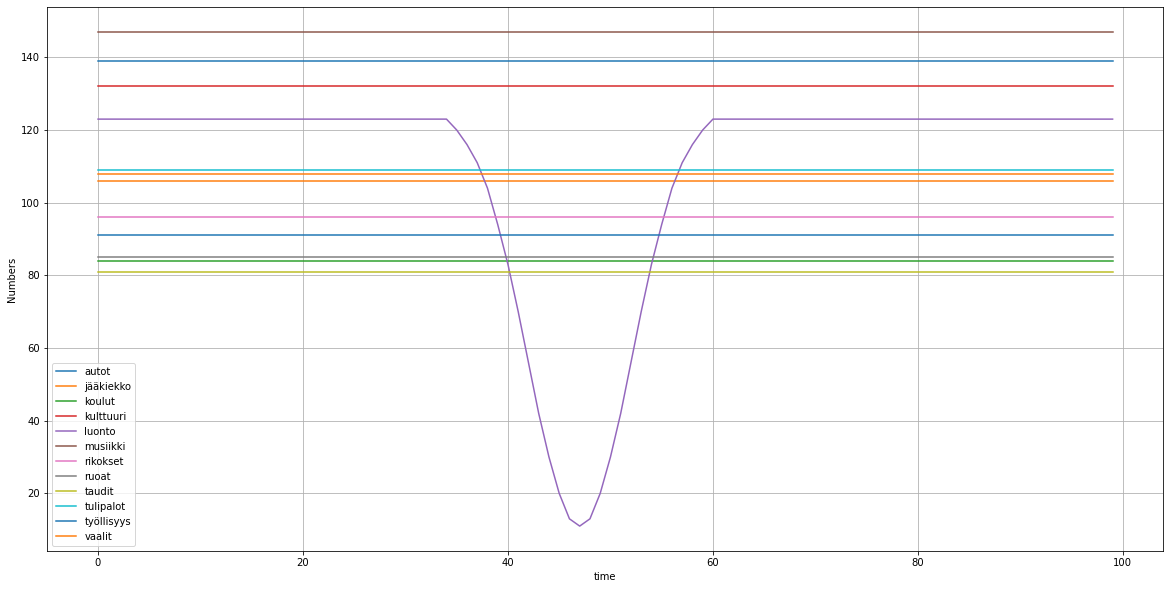

In [4]:
visualize_trending(dataset[0])

In [4]:
kmeans = pickle.load(open('data/prod/kmean_1k_models.pkl', 'rb'))

In [5]:
def get_cluster_freq_change(kmeans, samples, tracker, offset=0):
    
    all_changes = []
    
    for i, sample in enumerate(tqdm(samples)):
        #sample = pd.read_json('data/dev/samples/sample_' + str(i) + '.json')
        # sample.reset_index(inplace=True, drop=True)
        # sample_vecs = get_doc_vecs(doc_vecs, df, sample['id'])
        #target = get_target(sample)
        model = kmeans[i+offset]
        target = tracker.iloc[i]['category']
        # clusters = get_clusters(model.labels_, df, sample['id'])
        clusters = model.labels_

        events = tracker.iloc[i+offset]
        freq_change = get_cluster_change(clusters, sample, target, events)
        
        all_changes += freq_change
    
    return all_changes


def get_cluster_change(clusters, sample, target, event, timeline=100):
    sample['cluster'] = clusters
    n_cluster = sample['cluster'].nunique()
    changes = []
    
    for g, cluster in sample.groupby('cluster'):
        # count and sort by timeline
        counts = cluster['time'].value_counts().sort_index()
        if len(counts) < timeline:
            miss_times = list(set(range(timeline)).difference(counts.index))
            fill_values = pd.Series(np.zeros(len(miss_times)), index=miss_times)
            counts = counts.append(fill_values)
            counts = counts.sort_index()
            
        # print(cluster['time'].nunique())
        class_count = cluster['category'].value_counts(normalize=True)
        maj_class = class_count.index[0]
        maj_percent = class_count[0]
        # diff = times.diff().fillna(0)
        # print(class_count[0])
        is_target = (maj_class == target) #and maj_percent > 0.5
        p = event['pivots'] if is_target else []
        e = event['pattern'] if is_target else 'stable'
        
        changes.append((counts.values, is_target, maj_class, e, p))
        
    return changes

In [6]:
test_data = get_cluster_freq_change(kmeans, dataset, tracker)

100%|██████████| 1000/1000 [00:59<00:00, 16.89it/s]


In [9]:
X, _, maj_cats, z, y = zip(*test_data)

In [10]:
X = np.vstack(X)
X = minmax_scale(X, axis=1)

In [61]:
def cal_change_slope(freqs):
    X = np.arange(len(freqs))[:, np.newaxis]
    reg = LinearRegression(normalize=True).fit(X, freqs)
    
    return reg.coef_[0]

def get_slopes_window(freqs, timeline, window=5):
    steps = timeline - window + 1
    X = np.arange(window)[:, np.newaxis]
    
    slopes = np.zeros(steps)
    
    for i in range(steps):
        y = freqs[i:i+window]
        reg = LinearRegression(normalize=True).fit(X, y)
        slopes[i] = reg.coef_[0]
        
    return slopes

def get_batch_slopes(changes, timeline, window=5):
    all_slopes = []
    categories = []
    x = np.arange(len(changes))
    
    for cluster, maj_class, freqs in changes:
        slopes = get_slopes_window(freqs, timeline, window)
        all_slopes.append(slopes)
        categories.append(maj_class)
    
    all_slopes = np.abs(np.array(all_slopes))
    #slopes = (slopes - slopes.min()) / (slopes.max() - slopes.min())
    
    return all_slopes, categories
    
    
def get_slopes(freqs, visualize=False):
    slopes = []
    #categories = []

    for freq in freqs:
        slope = cal_change_slope(freq)
        slopes.append(slope)
    #categories.append(c)
    
    slopes = np.abs(np.array(slopes))
    slopes = minmax_scale(slopes) #/ slopes.sum()
    
#     if visualize:
#         x = np.arange(len(freqs))
#         fig, ax = plt.subplots(figsize=(20, 10))
#         ax.bar(x, height=slopes, tick_label=categories)
#         ax.set(xlabel='Clusters', ylabel='Slopes')
    
    return slopes


def visualize_slopes(freqs, cats):
    slopes = []
    categories = []
    x = np.arange(len(cats))
    
    for f, c in zip(freqs, cats):
        slope = cal_change_slope(f)
        slopes.append(slope)
        categories.append(c)
    
    slopes = np.abs(np.array(slopes))
    slopes = (slopes - slopes.min()) / (slopes.max() - slopes.min())
    

    fig, ax = plt.subplots(figsize=(30, 20))
    ax.bar(x, height=slopes, tick_label=categories)
    #ax.set(xlabel='Clusters', ylabel='Slopes')
    
        
    ax.set_xlabel('Clusters', fontsize=30)
    ax.set_ylabel('Slopes', fontsize=30)
    
    for label in ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(45)
    ax.tick_params(axis='both', which='major', labelsize=30)
    
    #return slopes, categories

def visualize_slopes_window(slopes, cats, target):
    timeline = range(slopes.shape[1])
    
    fig, ax = plt.subplots(figsize=(20, 10))
    distance = 0
    slopes = slopes
    
    for i, c in enumerate(cats):
        if c == target:
            ax.plot(timeline, slopes[i] + distance, label=c, ls='--')
        else:
            ax.plot(timeline, slopes[i] + distance, label=c)
        
        distance += 2
    
    ax.set(xlabel='Clusters', ylabel='Slopes')
    ax.legend()
    ax.grid()
    fig.show()
    
def get_rupture_pivots(freqs, n):
    #algo = rpt.Pelt(model='l1', min_size=5, jump=5).fit(freqs)
    # algo = rpt.Dynp(model="l2").fit(freqs)
    algo = rpt.Window(width=5, model="l1", jump=5).fit(freqs)
    pivots = algo.predict(pen=0.5)
    
    return pivots

427


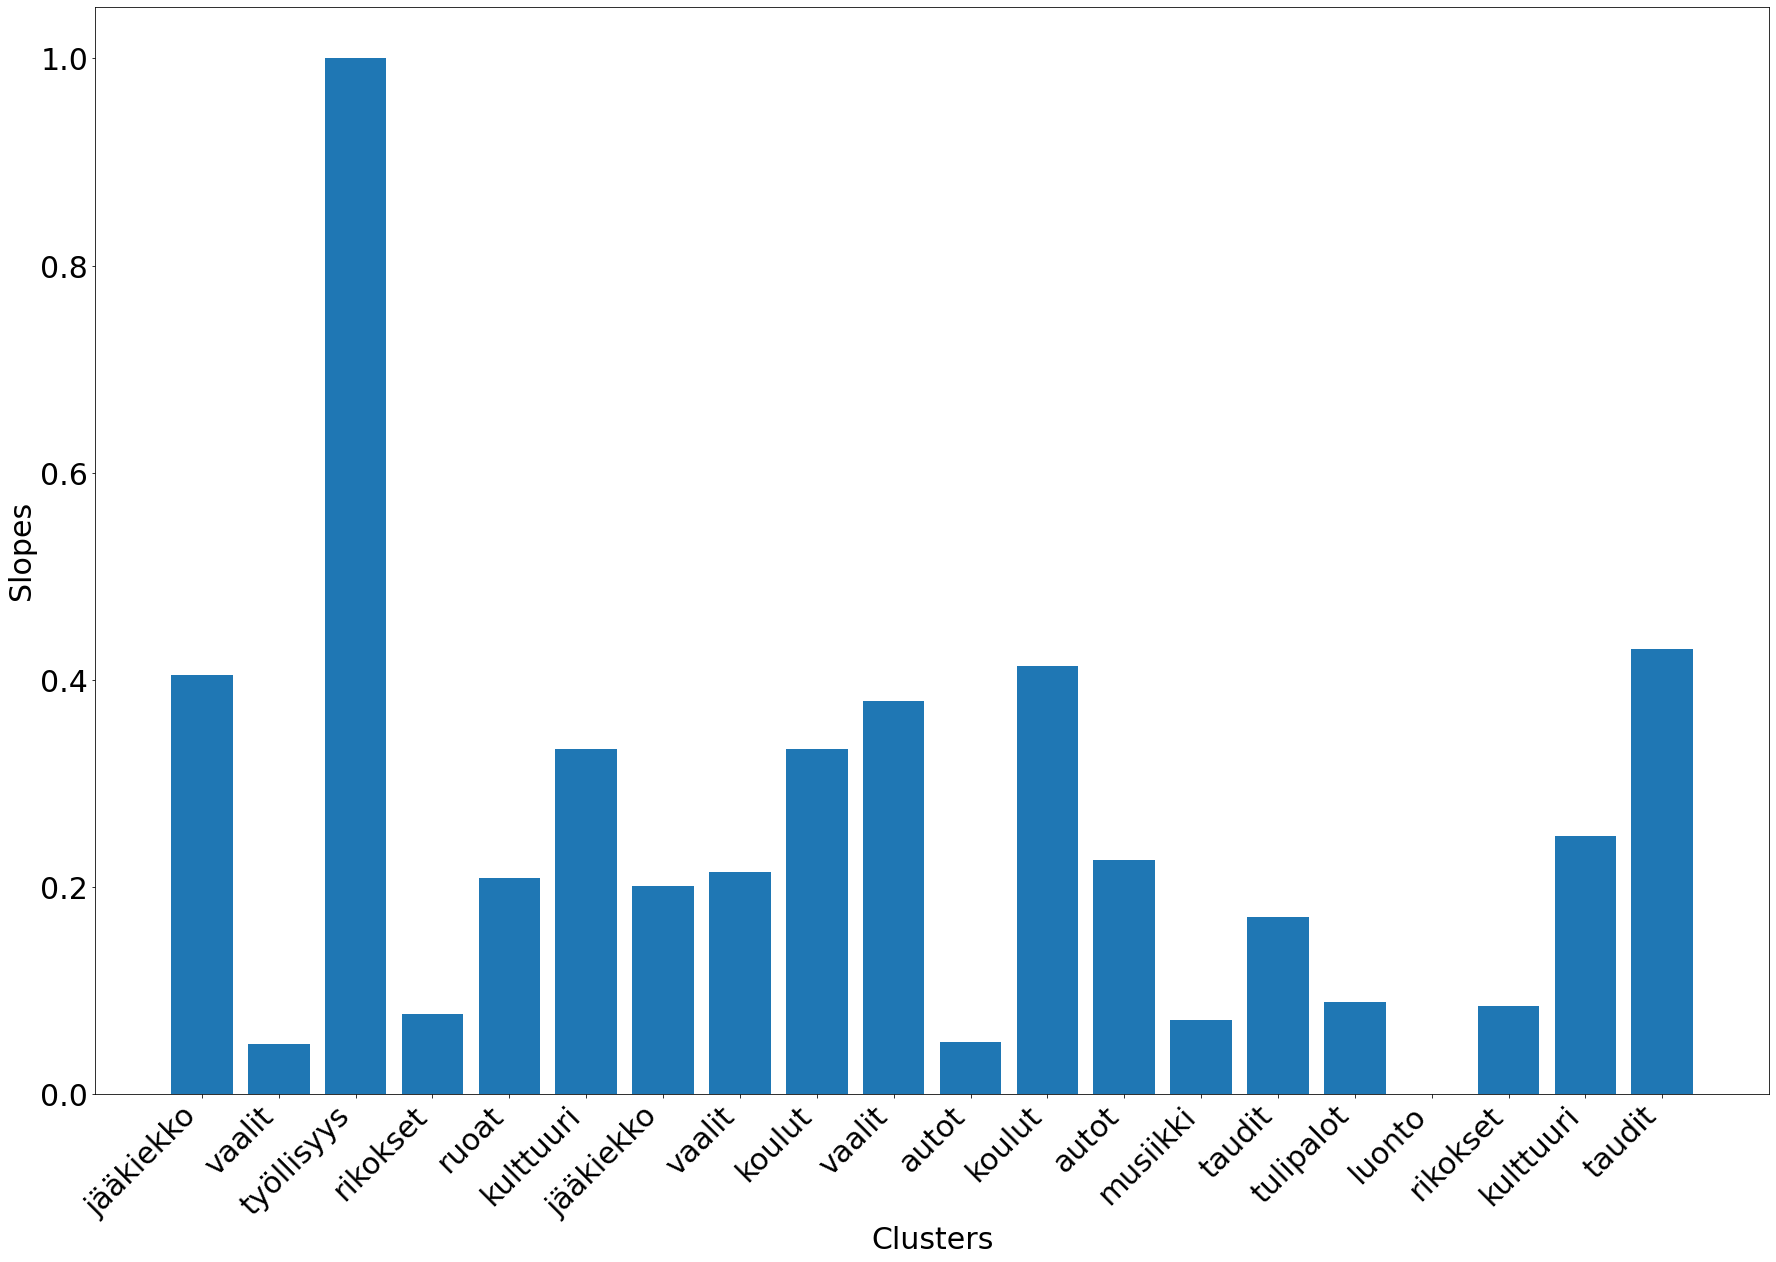

In [83]:
test_id = np.random.randint(1000) #599, 739, 862, 437, 49
print(test_id)

visualize_slopes(X[test_id*20:(test_id+1)*20], maj_cats[test_id*20:(test_id+1)*20])

In [23]:
get_rupture_pivots(X[2])

[10, 40, 65, 90, 100]

In [26]:
def get_metrics(df, freqs, pivots, maj_cats, target, threshold=0.5):
    accuracy = 0   # accuracy of detect correctly clusters have the target category as major
    precision = 0  # accuracy of detect how many articles in cluster are target category
    recall = 0    # accuracy of detect how many articles in target category are in choosen clusters
    randidx = 0
    timeline = 100
    
    slopes = get_slopes(freqs)
    
    preds = slopes >= threshold
    pred_ids = np.argwhere(preds).squeeze(1)
    n_cluster = len(pred_ids)
    

    df['target'] = (df['category'] == target)
    target_cluster = df[df['target'] == True]
    
    for i in pred_ids:
        #true_points = true_pivots[i]
        pred_points = get_rupture_pivots(freqs[i], len(pivots))
        
        true_points = np.concatenate((pivots, [timeline]), axis=0).astype(int)

        if timeline not in pred_points:
            pred_points = np.concatenate((pred_points, [timeline]), axis=0).astype(int)
        # print(t, p)
        randidx += randindex(true_points, pred_points)
    
    for i in pred_ids:
        pred_cat = maj_cats[i]
        cluster = df[df['cluster'] == i]
        
        if pred_cat == target:
            accuracy += 1
        # calculate the prec and recall
        if len(cluster['target']) > 0:
            precision += cluster['target'].mean()
        recall += cluster['target'].sum()
    
    # if there is output 
    if n_cluster:
        accuracy = accuracy / n_cluster
        precision = precision / n_cluster
        randidx = randidx / n_cluster
        recall = recall / target_cluster.shape[0]
    
    return accuracy, precision, recall, randidx, preds




In [78]:
cal_change_slope(X[])

0.0001656165616561655

In [37]:
y[:20]

([],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 array([34, 47, 61]),
 array([34, 47, 61]),
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [])

In [34]:
get_rupture_pivots(X[7], 0)

[100]

In [122]:
get_metrics(dataset[0], X[:20], y[:20], maj_cats[:20], tracker.iloc[0]['category'], threshold=0.7)

(0.125, 0.13038890873295234, 0.5702939565455541, 0.10562500000000001)

In [12]:
def evaluate_pipeline(samples, tracker, X, y, maj_cats, threshold=0.7):
    n_samples = len(samples)
    acc = np.zeros(n_samples)
    prc = np.zeros(n_samples)
    rec = np.zeros(n_samples)
    f = np.zeros(n_samples)
    rid = np.zeros(n_samples)
    n_cluster = 20
    y_bin = np.zeros(len(y), dtype=bool)
    
    for i, sample in enumerate(tqdm(samples)):
        target = tracker.iloc[i]['category']
        freqs = X[i*n_cluster: (i+1)*n_cluster]
        pivots = tracker.iloc[i]['pivots']
        #pivots = y[i*n_cluster: (i+1)*n_cluster]
        cats = maj_cats[i*n_cluster: (i+1)*n_cluster]

        # clusters = pickle.load(open("models/lda_cluster/clusters_" + str(i) + ".pkl", "rb"))
        
        acc[i], prc[i], rec[i], rid[i], pred_bin = get_metrics(sample, freqs, pivots, cats, target, threshold)
        y_bin[i*n_cluster: (i+1)*n_cluster] = pred_bin
        
        if (prc[i] + rec[i]) != 0:
            f[i] = 2 * prc[i] * rec[i] / (prc[i] + rec[i])
    
    true_bin = np.array([bool(len(p)) for p in y])
    
    print(classification_report(y_bin, true_bin, digits=4))
    
    return acc, prc, rec, rid, f


def get_report(y_bin, y_seq, label_points, timeline=100):
    true_bin = np.array([bool(len(p)) for p in label_points])

    print(classification_report(y_bin, true_bin, digits=4))
    randidx_pos = 0
    randidx_neg = 0
    count_neg = 0
    count_pos = 0
    
    for i, true_points in enumerate(label_points):
        true_points = np.concatenate((true_points, [timeline]), axis=0).astype(int)
        
        pred_points = get_pivots(y_seq[i])
        # print(pred_points)
        if timeline not in pred_points:
            pred_points = np.concatenate((pred_points, [timeline]), axis=0).astype(int)
            
        if len(pred_points) > 1:
            count_pos += 1
            randidx_pos += randindex(true_points, pred_points)
        else:
            count_neg += 1
            randidx_neg += randindex(true_points, pred_points)
        # print(t, p)
        # print(true_points)
        
    #print(len(true_bin), true_bin.sum(), count, randidx_neg, randidx_pos)
    print("Rand Index Positive:", randidx_pos/count_pos)
    print("Rand Index Negative:", randidx_neg/count_neg)

In [27]:
accs, precs, recs, rid, f_micro = evaluate_pipeline(dataset, tracker, X, y, maj_cats, 0.8)

100%|██████████| 1000/1000 [00:41<00:00, 24.17it/s]


              precision    recall  f1-score   support

       False     0.9458    0.9510    0.9484     18242
        True     0.4605    0.4340    0.4469      1758

    accuracy                         0.9055     20000
   macro avg     0.7031    0.6925    0.6976     20000
weighted avg     0.9031    0.9055    0.9043     20000



In [28]:
f_macro = 2 * precs.mean()*recs.mean()/(precs.mean()+recs.mean())
accs.mean(), precs.mean(), recs.mean(), rid.mean()

(0.5278083333333333,
 0.4398491259144738,
 0.3473216750314791,
 0.4252092183333333)

In [76]:
f_micro = np.nan_to_num(f_micro)
print("f_micro:", f_micro.mean(), "f_macro:", f_macro)

f_micro: 0.3704427613055903 f_macro: 0.38814736265664945
